In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import statsmodels.formula.api as smf
import seaborn as sp
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from datetime import datetime,timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df=pd.read_excel("Airlines+Data.xlsx")
df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [3]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [4]:
df.duplicated().sum()

0

# EDA

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Passengers'>

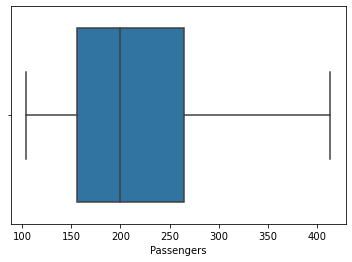

In [5]:
sp.boxplot(df["Passengers"])

In [6]:
df['Months'] = df['Month'].dt.strftime('%b')
df

,Month,Passengers,Months
0,1995-01-01,112,Jan
1,1995-02-01,118,Feb
2,1995-03-01,132,Mar
3,1995-04-01,129,Apr
4,1995-05-01,121,May
...,...,...,...
91,2002-08-01,405,Aug
92,2002-09-01,355,Sep
93,2002-10-01,306,Oct
94,2002-11-01,271,Nov


In [7]:
df1=pd.get_dummies(df["Months"])

In [8]:
df2 = pd.concat([df,df1],axis = 1)

In [9]:
df2["t"] = np.arange(1,97)
df2["t_squared"] = df2["t"]*df2["t"]

In [10]:
df2["log_Passengers"] = np.log(df2["Passengers"])

In [11]:
df2

,Month,Passengers,Months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_squared,log_Passengers
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0,1,1,4.718499
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0,2,4,4.770685
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0,3,9,4.882802
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0,4,16,4.859812
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0,5,25,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,Aug,0,1,0,0,0,0,0,0,0,0,0,0,92,8464,6.003887
92,2002-09-01,355,Sep,0,0,0,0,0,0,0,0,0,0,0,1,93,8649,5.872118
93,2002-10-01,306,Oct,0,0,0,0,0,0,0,0,0,0,1,0,94,8836,5.723585
94,2002-11-01,271,Nov,0,0,0,0,0,0,0,0,0,1,0,0,95,9025,5.602119


In [12]:
Train = df2.head(75)
Test = df2.tail(25)

In [13]:
linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
print("RMSE Linear: ",rmse_linear)

RMSE Linear:  51.83809749584508


In [14]:
Exp = smf.ols('log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  42.775259750198046


In [15]:
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  54.03140645625263


In [16]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  123.02763788084236


In [17]:
Mul_Add_sea = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print("RMSE Multiplicative Additive Seasonality:",rmse_Mult_add_sea )

RMSE Multiplicative Additive Seasonality: 11.565825437686053


In [18]:
data1 = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data1)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,51.838097
1,rmse_Exp,42.775260
2,rmse_Quad,54.031406
3,rmse_add_sea,123.027638
4,rmse_Mult_add_sea,11.565825


In [19]:
data = [['2003-01-01', 'Jan'], ['2003-02-01', 'Feb'], ['2003-03-01', 'Mar'],['2003-04-01', 'Apr'],['2003-5-01', 'May'],['2003-06-01', 'Jun'],
        ['2003-07-01', 'Jul'],['2003-08-01', 'Aug'],['2003-09-01', 'Sep'],['2003-10-01', 'Oct'],['2003-11-01', 'Nov'],['2003-12-01', 'Dec']]
forecast = pd.DataFrame(data, columns = ['Date', 'Months'])
forecast

,Date,Months
0,2003-01-01,Jan
1,2003-02-01,Feb
2,2003-03-01,Mar
3,2003-04-01,Apr
4,2003-5-01,May
5,2003-06-01,Jun
6,2003-07-01,Jul
7,2003-08-01,Aug
8,2003-09-01,Sep
9,2003-10-01,Oct


In [20]:
# Create dummies and T and T-Squared columns

dummies = pd.DataFrame(pd.get_dummies(forecast['Months']))
forecast1 = pd.concat([forecast,dummies],axis = 1)

forecast1["t"] = np.arange(1,13)   
forecast1["t_squared"] = forecast1["t"]*forecast1["t"] 
print("\nAfter Dummy, T and T-Square\n\n",forecast1.head())


After Dummy, T and T-Square

          Date Months  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  May  Nov  Oct  \
0  2003-01-01    Jan    0    0    0    0    1    0    0    0    0    0    0   
1  2003-02-01    Feb    0    0    0    1    0    0    0    0    0    0    0   
2  2003-03-01    Mar    0    0    0    0    0    0    0    1    0    0    0   
3  2003-04-01    Apr    1    0    0    0    0    0    0    0    0    0    0   
4   2003-5-01    May    0    0    0    0    0    0    0    0    1    0    0   

   Sep  t  t_squared  
0    0  1          1  
1    0  2          4  
2    0  3          9  
3    0  4         16  
4    0  5         25  


In [21]:
model_full = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data =df2).fit()
pred_new  = pd.Series(model_full.predict(forecast1))

forecast1["Forecasted_log"] = pd.Series(pred_new)
forecast1['Forecasted_Passengers'] = np.exp(forecast1['Forecasted_log'])

In [22]:
# Final Prediction for next 12 months

Final_predict = forecast1.loc[:, ['Date', 'Forecasted_Passengers']] 
Final_predict

,Date,Forecasted_Passengers
0,2003-01-01,109.176148
1,2003-02-01,110.331245
2,2003-03-01,127.315234
3,2003-04-01,123.200587
4,2003-5-01,122.399578
5,2003-06-01,138.536397
6,2003-07-01,154.066959
7,2003-08-01,153.741209
8,2003-09-01,137.693733
9,2003-10-01,120.894736


# Setting up month as index

In [23]:
df=pd.read_excel("Airlines+Data.xlsx")
df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [25]:
df.set_index(df["Month"],inplace=True)

In [26]:
df

,Month,Passengers
Month,,
1995-01-01,1995-01-01,112
1995-02-01,1995-02-01,118
1995-03-01,1995-03-01,132
1995-04-01,1995-04-01,129
1995-05-01,1995-05-01,121
...,...,...
2002-08-01,2002-08-01,405
2002-09-01,2002-09-01,355
2002-10-01,2002-10-01,306


In [27]:
df.drop("Month",axis=1,inplace=True)

In [28]:
df

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


# Augumented Dickey hypothesis

In [29]:
def adf_test(series):
    results=adfuller(series)
    print("Adf statistics:",results[0])
    print("p:",results[1])
    if results[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary")

In [30]:
adf_test(df["Passengers"])

Adf statistics: 1.340247959646701
p: 0.9968250481137263
Data is not stationary


# Differencing or integration

In [31]:
df["First Differencing"]=df["Passengers"]-df["Passengers"].shift(1)
df

,Passengers,First Differencing
Month,,
1995-01-01,112,NaN
1995-02-01,118,6.0
1995-03-01,132,14.0
1995-04-01,129,-3.0
1995-05-01,121,-8.0
...,...,...
2002-08-01,405,-8.0
2002-09-01,355,-50.0
2002-10-01,306,-49.0


In [32]:
adf_test(df["First Differencing"].dropna())

Adf statistics: -2.150001735920653
p: 0.22488942647512583
Data is not stationary


In [33]:
df["Second Differencing"]=df["First Differencing"]-df["First Differencing"].shift(1)
df

,Passengers,First Differencing,Second Differencing
Month,,,
1995-01-01,112,NaN,NaN
1995-02-01,118,6.0,NaN
1995-03-01,132,14.0,8.0
1995-04-01,129,-3.0,-17.0
1995-05-01,121,-8.0,-5.0
...,...,...,...
2002-08-01,405,-8.0,-47.0
2002-09-01,355,-50.0,-42.0
2002-10-01,306,-49.0,1.0


Second Differencing will be our intergeration
Adf statistics will be our d therefore try with 11 or 2

In [34]:
adf_test(df["Second Differencing"].dropna())

Adf statistics: -11.547980944840862
p: 3.5031802363202005e-21
Data is stationary


As the data now is stationary we will plot acf and pacf to find auto regression (RA) and moving average(ma)

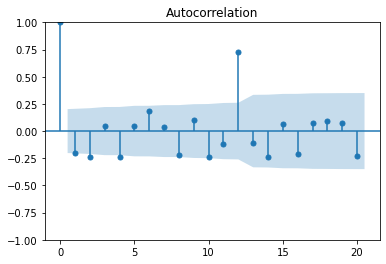

In [35]:
acf=plot_acf(df["Second Differencing"].dropna()) #here the number of lines above upper and lower limit will be 
                                                #the count for our auto regression(p) taht will impact the value to b forecasted

E:\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


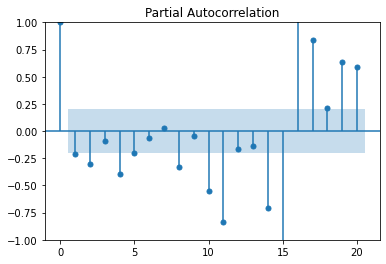

In [36]:
pacf=plot_pacf(df["Second Differencing"].dropna())
#here the number of lines above upper and lower limit will be the count for our moving average(q) taht will impact the value 
# to b forecasted

# Data spliting

In [37]:
df.shape

(96, 3)

In [38]:
train=df[:67]
train

,Passengers,First Differencing,Second Differencing
Month,,,
1995-01-01,112,NaN,NaN
1995-02-01,118,6.0,NaN
1995-03-01,132,14.0,8.0
1995-04-01,129,-3.0,-17.0
1995-05-01,121,-8.0,-5.0
...,...,...,...
2000-03-01,235,47.0,63.0
2000-04-01,227,-8.0,-55.0
2000-05-01,234,7.0,15.0


In [39]:
test=df.tail(29)
test

,Passengers,First Differencing,Second Differencing
Month,,,
2000-08-01,293,-9.0,-47.0
2000-09-01,259,-34.0,-25.0
2000-10-01,229,-30.0,4.0
2000-11-01,203,-26.0,4.0
2000-12-01,229,26.0,52.0
2001-01-01,242,13.0,-13.0
2001-02-01,233,-9.0,-22.0
2001-03-01,267,34.0,43.0
2001-04-01,269,2.0,-32.0


# Arima model

In [40]:
model_arima=sms.tsa.arima.ARIMA(df["Passengers"],order=(6,1,13)) # (p,d,q)

E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [41]:
model_arima_fit=model_arima.fit()

E:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
pred_start_date=test.index[0] #for prediction when it comes to time as index we have to only give the startdate and enddate
                              #for prediction function instead of the mentioning whole train test dataset
pred_end_date=test.index[-1]

In [43]:
pred_start_date

Timestamp('2000-08-01 00:00:00')

In [44]:
pred_end_date

Timestamp('2002-12-01 00:00:00')

# Prediction

In [45]:
pred=model_arima_fit.predict(pred_start_date,pred_end_date)
pred

2000-08-01    303.792670
2000-09-01    280.510663
2000-10-01    225.162451
2000-11-01    203.320583
2000-12-01    224.079878
2001-01-01    229.843252
2001-02-01    242.080506
2001-03-01    254.357264
2001-04-01    256.460075
2001-05-01    250.911244
2001-06-01    293.263466
2001-07-01    325.227781
2001-08-01    351.079020
2001-09-01    331.375175
2001-10-01    276.839540
2001-11-01    240.639922
2001-12-01    272.581312
2002-01-01    297.962567
2002-02-01    276.580777
2002-03-01    289.810251
2002-04-01    321.590884
2002-05-01    304.988797
2002-06-01    356.339440
2002-07-01    413.416509
2002-08-01    390.526297
2002-09-01    373.819054
2002-10-01    324.354188
2002-11-01    280.030602
2002-12-01    314.679092
Freq: MS, Name: predicted_mean, dtype: float64

In [46]:
residuals=test["Passengers"]-pred
residuals

Month
2000-08-01   -10.792670
2000-09-01   -21.510663
2000-10-01     3.837549
2000-11-01    -0.320583
2000-12-01     4.920122
2001-01-01    12.156748
2001-02-01    -9.080506
2001-03-01    12.642736
2001-04-01    12.539925
2001-05-01    19.088756
2001-06-01    21.736534
2001-07-01    38.772219
2001-08-01    -4.079020
2001-09-01   -19.375175
2001-10-01    -2.839540
2001-11-01    -3.639922
2001-12-01     5.418688
2002-01-01   -13.962567
2002-02-01     0.419223
2002-03-01    27.189749
2002-04-01    -8.590884
2002-05-01    13.011203
2002-06-01    17.660560
2002-07-01    -0.416509
2002-08-01    14.473703
2002-09-01   -18.819054
2002-10-01   -18.354188
2002-11-01    -9.030602
2002-12-01    -8.679092
dtype: float64

In [47]:
test["arima"]=pred
test["residuals"]=residuals

C:\Users\DHAVAL\AppData\Local\Temp\ipykernel_16632\3640794944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["arima"]=pred
C:\Users\DHAVAL\AppData\Local\Temp\ipykernel_16632\3640794944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["residuals"]=residuals


In [48]:
test

,Passengers,First Differencing,Second Differencing,arima,residuals
Month,,,,,
2000-08-01,293,-9.0,-47.0,303.792670,-10.792670
2000-09-01,259,-34.0,-25.0,280.510663,-21.510663
2000-10-01,229,-30.0,4.0,225.162451,3.837549
2000-11-01,203,-26.0,4.0,203.320583,-0.320583
2000-12-01,229,26.0,52.0,224.079878,4.920122
2001-01-01,242,13.0,-13.0,229.843252,12.156748
2001-02-01,233,-9.0,-22.0,242.080506,-9.080506
2001-03-01,267,34.0,43.0,254.357264,12.642736
2001-04-01,269,2.0,-32.0,256.460075,12.539925


In [49]:
test.columns

Index(['Passengers', 'First Differencing', 'Second Differencing', 'arima',
       'residuals'],
      dtype='object')

<AxesSubplot:xlabel='Month'>

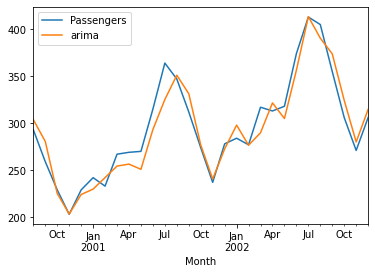

In [50]:
test[['Passengers','arima']].plot()

# SARIMAX

In [51]:
df["12th Differencing"]=df["Second Differencing"]-df["Second Differencing"].shift(12)
df

,Passengers,First Differencing,Second Differencing,12th Differencing
Month,,,,
1995-01-01,112,NaN,NaN,NaN
1995-02-01,118,6.0,NaN,NaN
1995-03-01,132,14.0,8.0,NaN
1995-04-01,129,-3.0,-17.0,NaN
1995-05-01,121,-8.0,-5.0,NaN
...,...,...,...,...
2002-08-01,405,-8.0,-47.0,19.0
2002-09-01,355,-50.0,-42.0,-24.0
2002-10-01,306,-49.0,1.0,4.0


In [52]:
adf_test(df["12th Differencing"].dropna())

Adf statistics: -6.098506833126328
p: 9.965734223559897e-08
Data is stationary


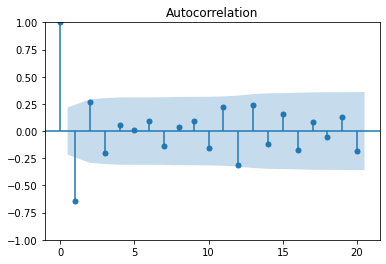

In [53]:
acf=plot_acf(df["12th Differencing"].dropna())

E:\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


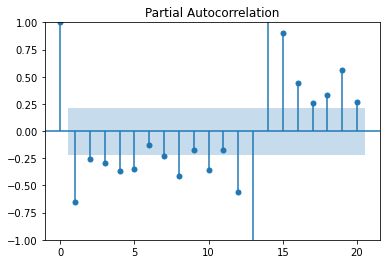

In [54]:
pacf=plot_pacf(df["12th Differencing"].dropna())

In [55]:
sarima=SARIMAX(df["Passengers"],order=(6,1,13),seasonal_order=(0,1,0,12)) #seasonal_order=
                                                                          #(p,d,q) for sarimax and last is seasonal as it is seasonal dataset so it is 12

E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [56]:
model=sarima.fit()

E:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [57]:
pred=model.predict(pred_start_date,pred_end_date)
pred

2000-08-01    303.228260
2000-09-01    266.558030
2000-10-01    234.064789
2000-11-01    199.482138
2000-12-01    221.687810
2001-01-01    224.119993
2001-02-01    228.699271
2001-03-01    271.807187
2001-04-01    258.645283
2001-05-01    261.891696
2001-06-01    310.780122
2001-07-01    351.343991
2001-08-01    355.357085
2001-09-01    306.373277
2001-10-01    276.660043
2001-11-01    242.502188
2001-12-01    264.684355
2002-01-01    282.459825
2002-02-01    273.318427
2002-03-01    311.861516
2002-04-01    315.244897
2002-05-01    313.258952
2002-06-01    363.110976
2002-07-01    417.607575
2002-08-01    404.021167
2002-09-01    363.213138
2002-10-01    315.124446
2002-11-01    271.078563
2002-12-01    309.517206
Freq: MS, Name: predicted_mean, dtype: float64

In [58]:
test["sarimax"]=pred

C:\Users\DHAVAL\AppData\Local\Temp\ipykernel_16632\3951005328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["sarimax"]=pred


In [59]:
test

,Passengers,First Differencing,Second Differencing,arima,residuals,sarimax
Month,,,,,,
2000-08-01,293,-9.0,-47.0,303.792670,-10.792670,303.228260
2000-09-01,259,-34.0,-25.0,280.510663,-21.510663,266.558030
2000-10-01,229,-30.0,4.0,225.162451,3.837549,234.064789
2000-11-01,203,-26.0,4.0,203.320583,-0.320583,199.482138
2000-12-01,229,26.0,52.0,224.079878,4.920122,221.687810
2001-01-01,242,13.0,-13.0,229.843252,12.156748,224.119993
2001-02-01,233,-9.0,-22.0,242.080506,-9.080506,228.699271
2001-03-01,267,34.0,43.0,254.357264,12.642736,271.807187
2001-04-01,269,2.0,-32.0,256.460075,12.539925,258.645283


<AxesSubplot:xlabel='Month'>

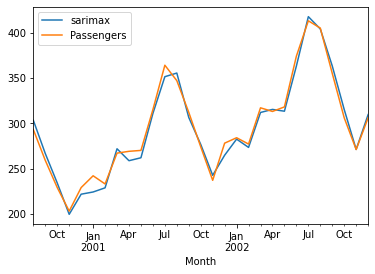

In [62]:
test[["sarimax","Passengers"]].plot()